# Performance showcase of novel "to_sql" functionality in mlinspect

Here the performance of the proposed inspection using sql will be compared to the original one in pandas. Part of
the "healthcare" and "compas" pipeline will be used.

## Required packages:
See: requirements/requirements.txt and requirements/requirements.dev.txt

## Some parameters you might want to set:

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import timeit
from inspect import cleandoc
from mlinspect.utils import get_project_root
from _code_as_string import get_healthcare_pipe_code, get_compas_pipe_code, print_generated_code
from _benchmark_utility import plot_compare

DO_CLEANUP = True
SIZES = [(10 ** i) for i in range(2, 5, 1)]
BENCH_REP = 2
MLINSPECT_ROOT_DIR = get_project_root()

# DBMS related:
UMBRA_DIR = r"/home/luca/Documents/Bachelorarbeit/umbra-students"
UMBRA_USER = "postgres"
UMBRA_PW = " "
UMBRA_DB = ""
UMBRA_PORT = 5433
UMBRA_HOST = "/tmp/"

POSTGRES_USER = "luca"
POSTGRES_PW = "password"
POSTGRES_DB = "healthcare_benchmark"
POSTGRES_PORT = 5432
POSTGRES_HOST = "localhost"

# Data GenerationCTE

To be able to benchmark and compare the different approaches, some datasets
will need to be generated before. The datasets are just and expansion of the
original ones.

In [2]:
!{sys.executable} -m pip install faker

from data_generation.compas_data_generation import generate_compas_dataset
from data_generation.healthcare_data_generation import generate_healthcare_dataset

# We only generate the files, that are not already existing:

COMPAS_DATA_PATHS = generate_compas_dataset(SIZES)
HEALTHCARE_DATA_PATHS = generate_healthcare_dataset(SIZES)

You should consider upgrading via the '/home/luca/Documents/Bachelorarbeit/mlinspect/venv/bin/python -m pip install --upgrade pip' command.
Data generated or found for: size = 100 -- compas
Data generated or found for: size = 1000 -- compas
Data generated or found for: size = 10000 -- compas
Data generated or found for: size = 100 -- healthcare
Data generated or found for: size = 1000 -- healthcare
Data generated or found for: size = 10000 -- healthcare


## Benchmark setup:

In [3]:
def get_inspection_code(pipeline_code, to_sql, dbms_connector, no_bias, mode, materialize=False,
                                   one_run=False):
    setup_code = cleandoc(f"""
from inspect import cleandoc
from mlinspect.utils import get_project_root
from mlinspect import PipelineInspector
from mlinspect.inspections import RowLineage, MaterializeFirstOutputRows
from mlinspect.checks import NoBiasIntroducedFor, NoIllegalFeatures
from demo.feature_overview.no_missing_embeddings import NoMissingEmbeddings
from inspect import cleandoc
from example_pipelines.healthcare import custom_monkeypatching
from mlinspect.to_sql.dbms_connectors.postgresql_connector import PostgresqlConnector
from mlinspect.to_sql.dbms_connectors.umbra_connector import UmbraConnector
from mlinspect import PipelineInspector

dbms_connector_u = UmbraConnector(dbname=\'{UMBRA_DB}\', user=\'{UMBRA_USER}\', password=\'{UMBRA_PW}\',
    port={UMBRA_PORT}, host=\'{UMBRA_HOST}\', umbra_dir= r\'{UMBRA_DIR}\')
dbms_connector_p = PostgresqlConnector(dbname=\'{POSTGRES_DB}\', user=\'{POSTGRES_USER}\',
    password=\'{POSTGRES_PW}\', port={POSTGRES_PORT}, host=\'{POSTGRES_HOST}\')

pipeline_code = cleandoc(f\"\"\"{pipeline_code}\"\"\")

pipeline_inspector = PipelineInspector.on_pipeline_from_string(pipeline_code) \\
    .add_custom_monkey_patching_module(custom_monkeypatching) \\
    .add_check(NoBiasIntroducedFor({no_bias})) \\
    .add_check(NoIllegalFeatures()) \\
    .add_check(NoMissingEmbeddings()) \\
    .add_required_inspection(RowLineage(5)) \\
    .add_required_inspection(MaterializeFirstOutputRows(5))
    """) + "\n"
    if to_sql:
        return setup_code, f"pipeline_inspector.execute_in_sql(dbms_connector={dbms_connector}, " \
                           f"sql_one_run={one_run}, mode=\'{mode}\', materialize={materialize})"

    return setup_code, f"pipeline_inspector.execute()"


def run(pipeline_code, to_sql=False, dbms_connector=None, no_bias=None, mode=None, materialize=False, one_run=False):
    setup_code, test_code = get_inspection_code(pipeline_code, to_sql, dbms_connector, no_bias,
                                                           mode, materialize, one_run)
    if to_sql:
        result = []
        for i in range(BENCH_REP):
            # print(f"run {i} of {BENCH_REP} ...")
            # This special case is necessary to deduct the time for dropping the existing tables and views!
            result.append(timeit.timeit(test_code, setup=setup_code, number=1) * 1000)  # in s
        return sum(result) / BENCH_REP

    return (timeit.timeit(test_code, setup=setup_code, number=BENCH_REP) / BENCH_REP) * 1000  # in s


def pipeline_inspection_benchmark(data_paths, no_bias, mode, title, materialize=False, exclude_umbra=False,
                                  display_hardware_usage: bool = False):
    pandas_times = []
    postgres_times = []
    umbra_times = []
    for i, (path_to_csv_1, path_to_csv_2) in enumerate(data_paths):

        if "compas" in str(path_to_csv_1):
            setup_code, test_code = get_compas_pipe_code(path_to_csv_1, path_to_csv_2)
        elif "healthcare" in str(path_to_csv_1):
            setup_code, test_code = get_healthcare_pipe_code(path_to_csv_1, path_to_csv_2)
        else:
            assert False
        pipe_code = setup_code + test_code

        print(f"Running pandas...  -- size {SIZES[i]}")
        pandas_times.append(run(pipe_code, to_sql=False, dbms_connector=None, no_bias=no_bias))
        print(f"Running postgres...  -- size {SIZES[i]}")
        postgres_times.append(run(pipe_code, True, "dbms_connector_p", no_bias, mode=mode, materialize=materialize))
        if not exclude_umbra:
            print(f"Running umbra... -- size {SIZES[i]}")
            umbra_times.append(run(pipe_code, True, "dbms_connector_u", no_bias, mode=mode, materialize=materialize))

        # sys.argv = ["psrecord", "--duration=100", "--log=activity.txt", "1540"]
        # main()

    names = ["Pandas", "Postgresql", "Umbra"]
    table = [pandas_times, postgres_times, umbra_times]
    if exclude_umbra:
        names = names[:-1]
        table = table[:-1]
    plot_compare(title, SIZES, all_y=table, all_y_names=names, save=True)

## Benchmark of default inspection using CTEs:

In [4]:
healthcare_no_bias = "[\'age_group\', \'race\']"
compas_no_bias = "[\'sex\', \'race\']"

# Example of the SQL code that gets generated for healthcare with CTE:
set_up, test = get_healthcare_pipe_code(*HEALTHCARE_DATA_PATHS[-1])
set_up, test = get_inspection_code(set_up+test, to_sql=True, dbms_connector=None,
                                          no_bias=healthcare_no_bias, mode="CTE", materialize=False, one_run=False)
exec(set_up+test)

# print_generated_code()


Just translation to SQL is performed! 
-> SQL-Code placed at: mlinspect/to_sql/generated_code



2021-07-30 09:12:45.038140: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-07-30 09:12:45.038167: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Running pandas...  -- size 100
Running postgres...  -- size 100
Running umbra... -- size 100
Running pandas...  -- size 1000
Running postgres...  -- size 1000
Running umbra... -- size 1000
Running pandas...  -- size 10000
Running postgres...  -- size 10000
Running umbra... -- size 10000


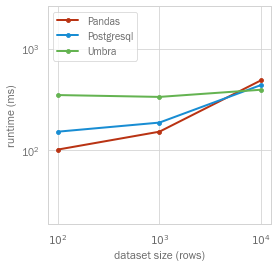

In [5]:
pipeline_inspection_benchmark(HEALTHCARE_DATA_PATHS, healthcare_no_bias, mode="CTE",
                              title="HealthcareInspectionComparisonCTE")

Running pandas...  -- size 100
Running postgres...  -- size 100
Running umbra... -- size 100
Running pandas...  -- size 1000
Running postgres...  -- size 1000
Running umbra... -- size 1000
Running pandas...  -- size 10000
Running postgres...  -- size 10000
Running umbra... -- size 10000


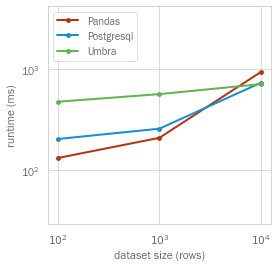

In [6]:
pipeline_inspection_benchmark(COMPAS_DATA_PATHS, compas_no_bias, mode="CTE",
                              title="CompasInspectionComparisonCTE")

## Benchmark of default inspection using VIEWs:

In [7]:
# The SQL code that gets generated for compas with VIEW:
set_up, test = get_compas_pipe_code(*COMPAS_DATA_PATHS[0])
set_up, test = get_inspection_code(set_up+test, to_sql=True, dbms_connector=None,
                                          no_bias=healthcare_no_bias, mode="VIEW", materialize=False, one_run=False)
exec(set_up+test)

# print_generated_code()



Just translation to SQL is performed! 
-> SQL-Code placed at: mlinspect/to_sql/generated_code



Running pandas...  -- size 100
Running postgres...  -- size 100
Running umbra... -- size 100
Running pandas...  -- size 1000
Running postgres...  -- size 1000
Running umbra... -- size 1000
Running pandas...  -- size 10000
Running postgres...  -- size 10000
Running umbra... -- size 10000


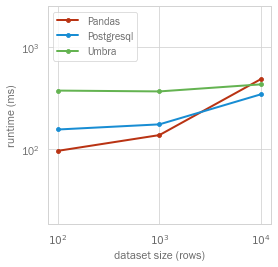

In [8]:
pipeline_inspection_benchmark(HEALTHCARE_DATA_PATHS, healthcare_no_bias, mode="VIEW",
                              title="HealthcareInspectionComparisonVIEW")

Running pandas...  -- size 100
Running postgres...  -- size 100
Running umbra... -- size 100
Running pandas...  -- size 1000
Running postgres...  -- size 1000
Running umbra... -- size 1000
Running pandas...  -- size 10000
Running postgres...  -- size 10000
Running umbra... -- size 10000


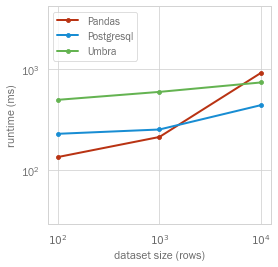

In [9]:
pipeline_inspection_benchmark(COMPAS_DATA_PATHS, compas_no_bias, mode="VIEW",
                              title="CompasInspectionComparisonVIEW")

## Benchmark of default inspection using MATERIALIZED VIEWs:

While doing the default inspection, parts of the generated code get executed multiple times. This is the reason
the option to MATERIALIZE Views, called more that once, got added. This way NO part of the pipeline is executed
more that ONCE.

In our case only postgres supports this option.

Running pandas...  -- size 100
Running postgres...  -- size 100
Running pandas...  -- size 1000
Running postgres...  -- size 1000
Running pandas...  -- size 10000
Running postgres...  -- size 10000


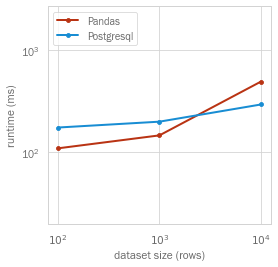

In [10]:
pipeline_inspection_benchmark(HEALTHCARE_DATA_PATHS, healthcare_no_bias, mode="VIEW", materialize=True,
                              exclude_umbra=True, title="HealthcareInspectionComparisonVIEWMAT")

In [11]:
# SQL code that got generated for healthcare with VIEW with the MATERIALIZE OPTION:
# print_generated_code()


## Main memory usage consideration:

Despite the improved runtime, also the main memory usage can profit from relying
on a DBMS. This can be also seen with Grizzly: https://edbt2021proceedings.github.io/docs/p174.pdf

This code for example requires more than 32GB in main memory to run:

In [12]:
size = (10 ** 6)
path_to_csv_his, path_to_csv_pat = generate_healthcare_dataset([size])[0]
setup_code, test_code = get_healthcare_pipe_code(path_to_csv_his, path_to_csv_pat, add_impute_and_onehot=True)
setup_code += "\n" + "from sklearn.impute import SimpleImputer" + \
                "\n" + "from sklearn.pipeline import Pipeline" + \
                "\n" + "from sklearn.preprocessing import OneHotEncoder, StandardScaler" + "\n"

test_code += "\n" + "test = impute_and_one_hot_encode.fit_transform(data)"

pipe_code = setup_code + test_code


Data generated or found for: size = 1000000 -- healthcare


In [13]:
# Requires trough swiftly:
print(f"Running postgres...  -- size {size}")
print("postgres_times: " + str(run(pipe_code, True, "dbms_connector_p", no_bias=healthcare_no_bias, mode="CTE",
                          materialize=False)))

Running postgres...  -- size 1000000


KeyboardInterrupt: 

In [ ]:
# Requires lots of memory (600+ GiB):
print(f"Running pandas...  -- size {size}")
print("pandas_times * " + str(run(pipe_code, to_sql=False, dbms_connector=None, no_bias=healthcare_no_bias)))


